In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt

mpl.rcParams['figure.max_open_warning'] = 30

select results file and get necessary parameters

In [2]:
# trialregs_dot = 0
# resfile = helpers.resultsdir + '/meg_sequential_201703011624.h5'

# trialregs_dot = 0, baseline = None
# resfile = helpers.resultsdir + '/meg_sequential_201703161743.h5'

# trialregs_dot = 5, baseline = None
# resfile = helpers.resultsdir + '/meg_sequential_201703161307.h5'

# trialregs_dot = 5
# resfile = helpers.resultsdir + '/meg_sequential_201703011927.h5'

# trialregs_dot = 0, baseline = None, choice flipped dot_x and accev
# resfile = helpers.resultsdir + '/meg_sequential_201705311314.h5'

# source GLM, trialregs_dot = 5, baseline = (-0.3, 0), choice flipped dot_x and accev
resfile = helpers.resultsdir + '/source_sequential_201706141650.h5'

#evoked = helpers.load_evoked_container(window=pd.read_hdf(resfile, 'window'))
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


plotting functions

In [3]:
stylecycler = cycle([':', '--', '-.'])
def plot_minmax_regressors(results, r_names, measure, nperm=0, mode='absmax'):
    if mode == 'max':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').max(
            level='time').plot(y=r_names);
    elif mode == 'min':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').min(
            level='time').abs().plot(y=r_names);
    elif mode == 'absmax':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).max(level='time').plot(y=r_names)
    elif mode == 'absmean':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).mean(level='time').plot(y=r_names)
        
    cols = [l.get_color() for l in ax.get_lines()]

    nperm += 1
    
    for perm in perms[1:nperm]:
        if mode == 'max':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').max(
                level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'min':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').min(
                level='time').abs().plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmax':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).max(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmean':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).mean(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))

    lines = ax.get_lines()
    for i in range(len(r_names)):
        col = lines[i].get_color()
        for perm in perms[1:nperm]:
            lines[i + perm * len(r_names)].set_color(col)

def show_topology_at_peaks(results, r_name, measure, mode='absmax', order=4, vmin=-.1, vmax=.1):
    if mode == 'absmax':
        data = results.loc[0, (measure, r_name)].abs().max(level='time')
    elif mode == 'absmean':
        data = results.loc[0, (measure, r_name)].abs().mean(level='time')
    elif mode == 'max':
        data = results.loc[0, (measure, r_name)].max(level='time')
    else:
        data = results.loc[0, (measure, r_name)].min(level='time').abs()
    
    plt.figure()
    ax = data.plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data.values, 
                                                  np.greater, order=order)] / 1000
    
    data = results.loc[0, (measure, r_name)]
    ev = mne.EvokedArray(data.values.reshape(102, data.index.levels[1].size), 
                         evoked.info, tmin=data.index.levels[1][0], 
                         nave=480*5, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=vmin, vmax=vmax, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit=measure, 
                          outlines='skirt');
    

def plot_single_signal(fl_data, sl_data, label, r_name, ax=None):
    dat = fl_data.loc[(0, label, slice(None)), 
                      (slice(None), 'beta', r_name)]
    times = dat.index.get_level_values('time')
    
    if ax is None:
        fig, ax = plt.subplots()
        
    l = ax.plot(times, dat, color='.7', label='single subjects')
    l1 = ax.plot(times, sl_data.loc[(slice(1,3), label, slice(None)), ('mean', r_name)]
                               .reset_index('permnr')
                               .pivot(columns='permnr'), 
                 ':k', label='mean (permuted data)')
    l2 = ax.plot(times, sl_data.loc[(0, label, slice(None)), ('mean', r_name)], 
                 'k', lw=2, label='mean')
    
    ax.legend([l[0], l1[0], l2[0]], ['single subjects', 'mean (permuted data)', 'mean']);
    ax.set_title(label)
    ax.set_xlabel('time from dot onset (ms)')
    ax.set_ylabel('beta of ' + r_name + ' (z)')

# Second level analysis

this scales the betas by their standard error and then averages across subjects to get the second level mean

In [22]:
first_level = pd.read_hdf(resfile, 'first_level')
flt = (  first_level.xs('beta', level='measure', axis=1) 
       / first_level.xs('bse', level='measure', axis=1))
second_level = pd.concat([flt.mean(level='regressor', axis=1), 
                          flt.std(level='regressor', axis=1)], keys=['mean', 'std'], names=['measure'], axis=1)

del first_level, flt
perms = second_level.index.levels[0]

standard analysis: average betas across subjects to get the second level mean

In [4]:
first_level = pd.read_hdf(resfile, 'first_level')
second_level = pd.read_hdf(resfile, 'second_level')
perms = second_level.index.levels[0]

# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
tvals = (second_level.xs('mean', axis=1, level='measure')  / 
         second_level.xs('std', axis=1, level='measure') * np.sqrt(34))
tvals['accev'] = -tvals['accev']

### describe genuine regressors

In [5]:
measure = 'mean'

second_level.xs(measure, axis=1, level='measure').xs(0, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,response,trial_time
count,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000
mean,0.000137,-0.000101,-0.000020,0.000087,0.000036,0.000089,0.000055,0.000052,-0.000089,0.001026,-0.000149,-0.000289
std,0.004799,0.004022,0.009851,0.005790,0.003737,0.008029,0.003927,0.004442,0.009861,0.023792,0.008341,0.014957
min,-0.028352,-0.022564,-0.055347,-0.029594,-0.016961,-0.057244,-0.021014,-0.029286,-0.049291,-0.108546,-0.049989,-0.065884
25%,-0.002805,-0.002481,-0.004855,-0.003614,-0.002209,-0.003352,-0.002373,-0.002404,-0.006026,-0.012278,-0.005088,-0.009865
50%,0.000125,-0.000065,-0.000039,0.000030,0.000085,0.000073,0.000013,-0.000023,-0.000143,0.001360,-0.000172,0.000061
75%,0.003089,0.002303,0.005031,0.003667,0.002344,0.003484,0.002486,0.002419,0.005938,0.015232,0.004837,0.009236
max,0.027246,0.020729,0.051739,0.024364,0.017568,0.051306,0.018267,0.033938,0.048319,0.108776,0.040306,0.071687


### describe regressors of first permutation

In [6]:
second_level.xs(measure, axis=1, level='measure').xs(1, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accev_cflip,accsur_pca,dot_x,dot_x_cflip,dot_y,entropy,intercept,response,trial_time
count,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,18100.000000,1.810000e+04,1.810000e+04,18100.000000,18100.000000,18100.000000,18100.000000
mean,0.000008,0.000025,-0.000007,-0.000060,-0.000050,0.000004,-1.715068e-05,-1.624782e-05,0.000148,0.001023,-0.000006,0.000043
std,0.003890,0.003201,0.003706,0.004293,0.003696,0.003443,3.674481e-03,3.255056e-03,0.009626,0.023579,0.007575,0.007104
min,-0.017640,-0.015750,-0.014728,-0.020070,-0.017483,-0.016085,-1.785980e-02,-1.409965e-02,-0.040843,-0.108778,-0.029620,-0.035898
25%,-0.002388,-0.001966,-0.002327,-0.002713,-0.002366,-0.002141,-2.303249e-03,-2.028289e-03,-0.005772,-0.011821,-0.004754,-0.004348
50%,0.000041,0.000044,-0.000017,-0.000076,-0.000022,0.000017,1.446507e-07,-4.163662e-07,0.000126,0.001430,-0.000012,0.000059
75%,0.002448,0.001988,0.002274,0.002594,0.002281,0.002142,2.277394e-03,1.955215e-03,0.006076,0.014850,0.004778,0.004389
max,0.019438,0.014028,0.016278,0.022083,0.016577,0.016215,2.234872e-02,1.562013e-02,0.042720,0.104531,0.033122,0.032779


## Show evolution of max (across channels) through the trial

principle regressors of interest

<IPython.core.display.Javascript object>


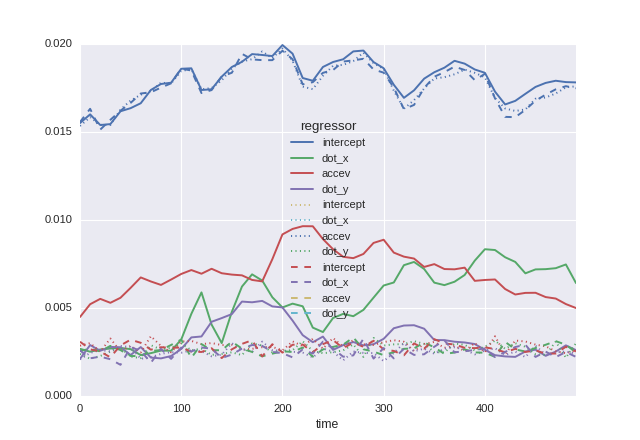

In [7]:
reg = ['intercept', 'dot_x', 'accev', 'dot_y']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

surprise regressors

<IPython.core.display.Javascript object>


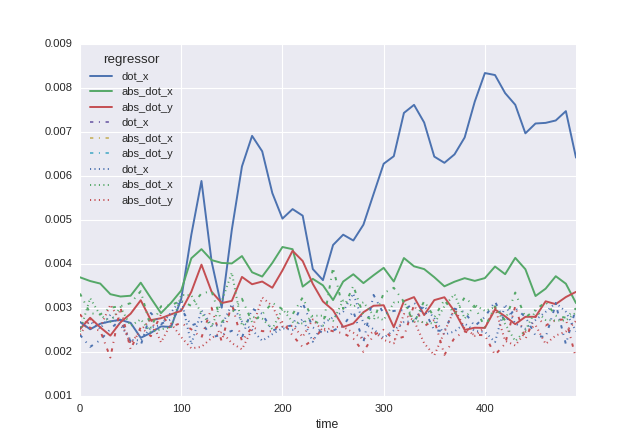

In [8]:
plot_minmax_regressors(second_level, ['dot_x', 'abs_dot_x', 'abs_dot_y'], 
                       measure, nperm=2, mode='absmean')

trial regressors

<IPython.core.display.Javascript object>


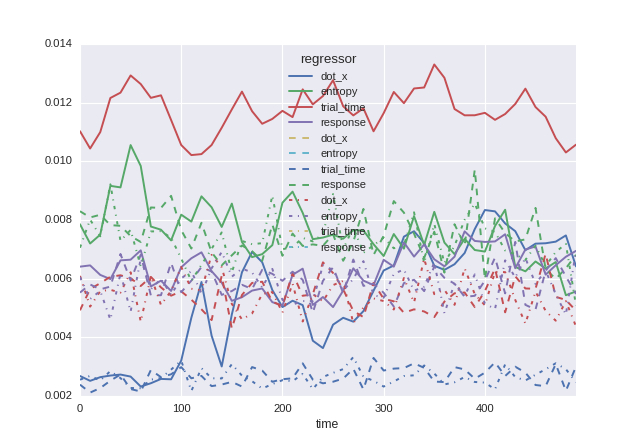

In [9]:
plot_minmax_regressors(second_level, ['dot_x', 'entropy', 'trial_time', 'response'], 
                       measure, nperm=2, mode='absmean')

choice flipped evidence regressors

<IPython.core.display.Javascript object>


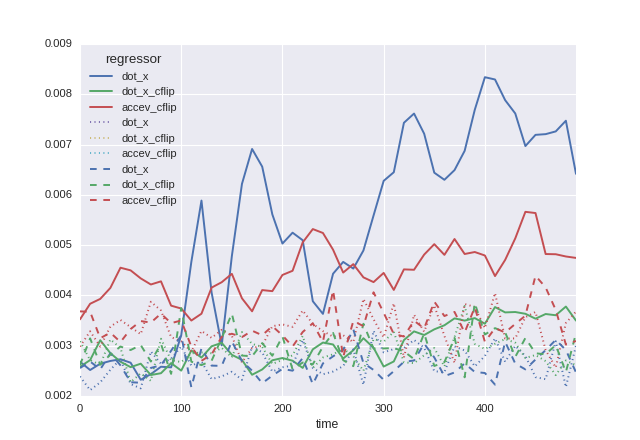

In [10]:
plot_minmax_regressors(second_level, ['dot_x', 'dot_x_cflip', 'accev_cflip'], 
                       measure, nperm=2, mode='absmean')

## Check distribution of a signal signal across time and subjects

<IPython.core.display.Javascript object>


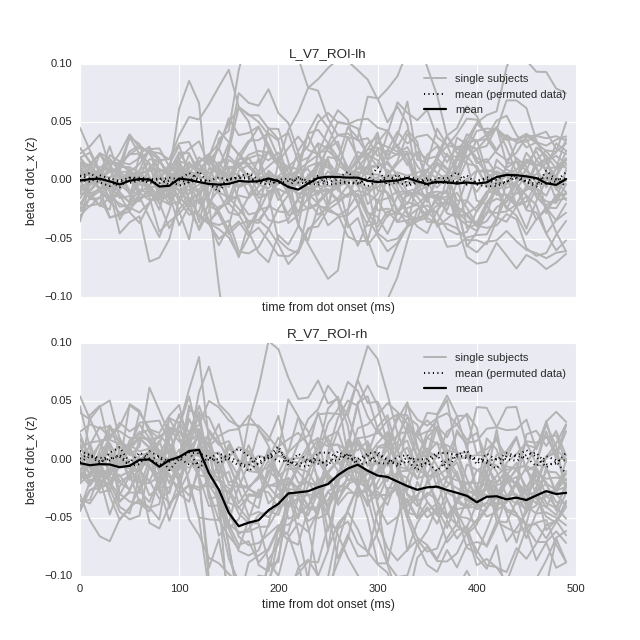

In [52]:
r_name = 'dot_x'
area = 'V7'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

<IPython.core.display.Javascript object>


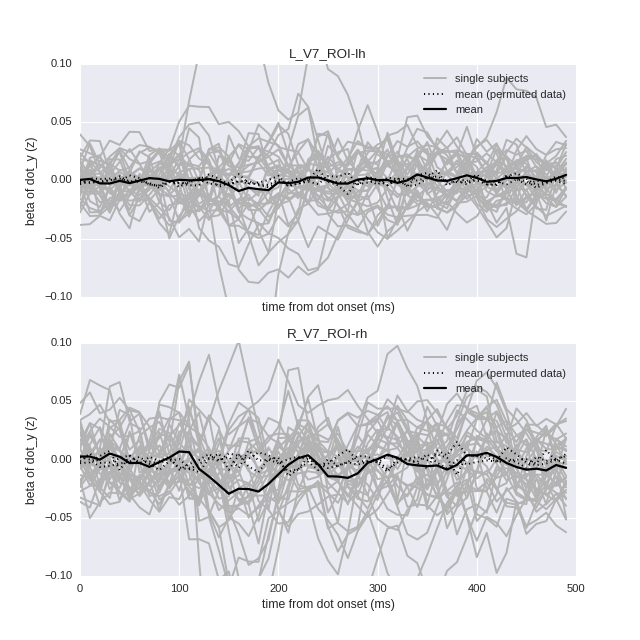

In [53]:
r_name = 'dot_y'
#area = 'LIPd'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

## Investigate topography (without baseline correction)

<IPython.core.display.Javascript object>


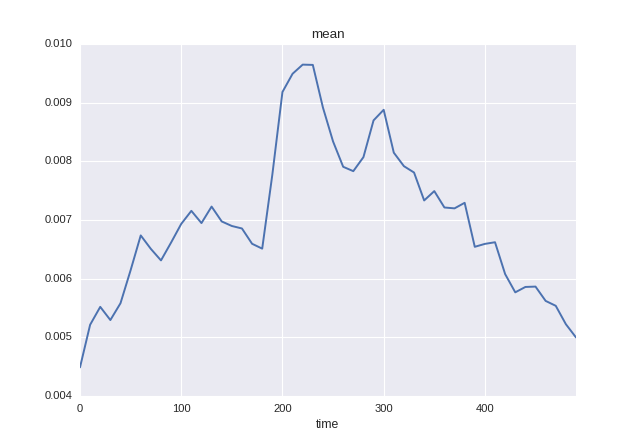

ValueError: total size of new array must be unchanged

In [75]:
show_topology_at_peaks(second_level, 'accev', 'mean', mode='absmean', order=3)

<IPython.core.display.Javascript object>


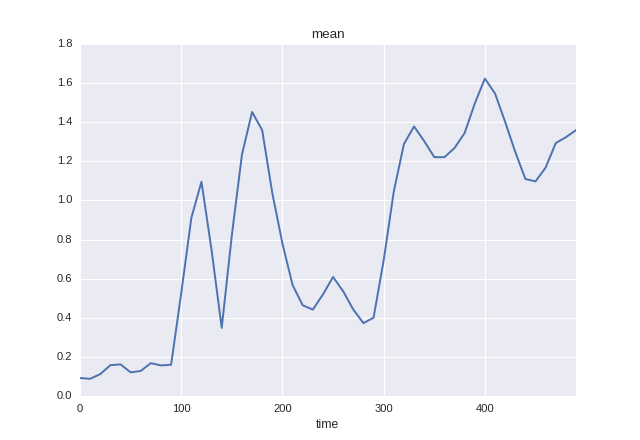

<IPython.core.display.Javascript object>


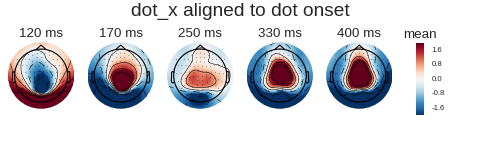

In [17]:
show_topology_at_peaks(second_level, 'dot_x', 'mean', mode='absmean', order=3, vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


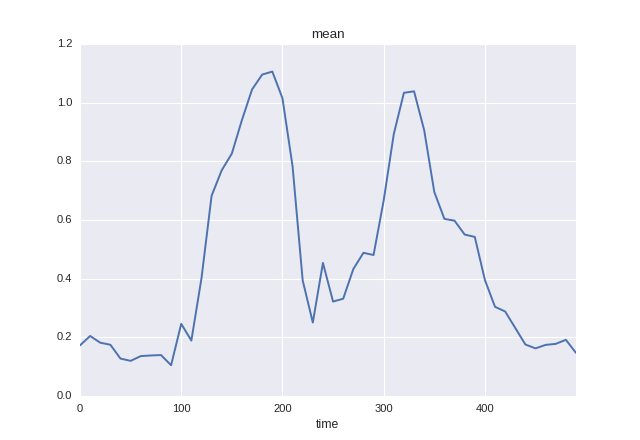

<IPython.core.display.Javascript object>


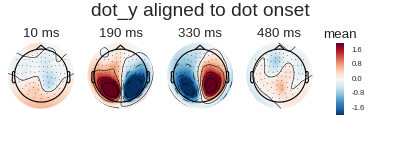

In [18]:
show_topology_at_peaks(second_level, 'dot_y', 'mean', mode='absmean', vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


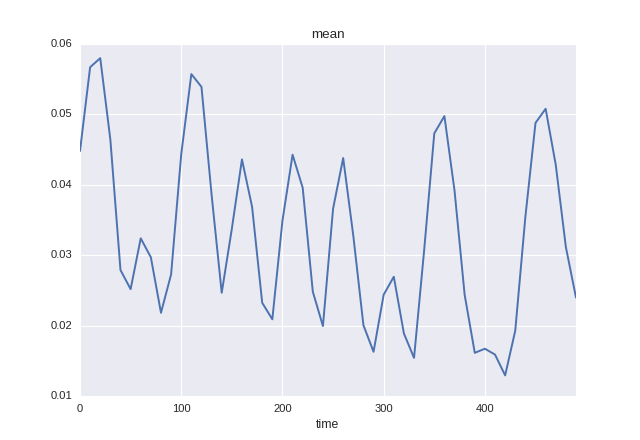

<IPython.core.display.Javascript object>


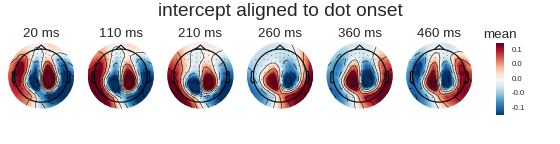

In [15]:
show_topology_at_peaks(second_level, 'intercept', 'mean', mode='absmean')

<IPython.core.display.Javascript object>


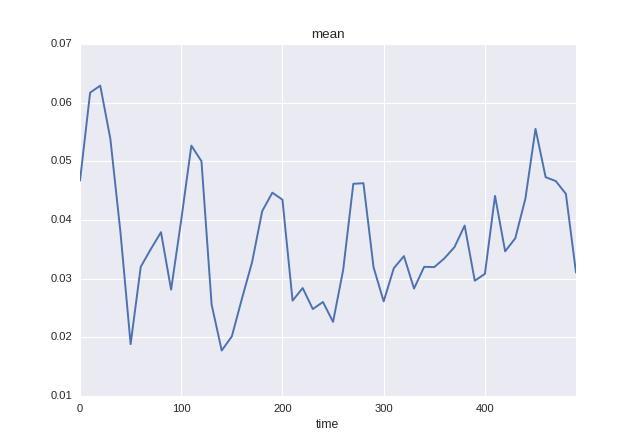

<IPython.core.display.Javascript object>


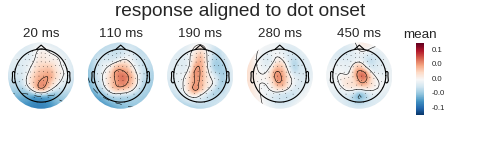

In [16]:
show_topology_at_peaks(second_level, 'response', 'mean')

# Check single subject results

In [6]:
first_level_diagnostics = pd.read_hdf(resfile, 'first_level_diagnostics')
first_level = pd.read_hdf(resfile, 'first_level')

In [12]:
first_level.columns.levels[1]

Index(['beta', 'bse'], dtype='object', name='measure')

In [16]:
sl2 = first_level.xs('beta', axis=1, level='measure').abs().mean(axis=1, level='regressor')
sl2.columns = pd.MultiIndex.from_product([['mean'], sl2.columns], names=['measure', 'regressor'])

In [17]:
sl2

measure                  mean                                           \
regressor           abs_dot_x abs_dot_y     accev accsur_pca     dot_x   
permnr channel time                                                      
0      MEG0111 0     0.022158  0.012504  0.024533   0.019484  0.019925   
               10    0.022488  0.012532  0.023444   0.019486  0.022248   
               20    0.022435  0.013733  0.024293   0.017851  0.017797   
               30    0.022644  0.015043  0.024593   0.019526  0.018390   
               40    0.023600  0.016181  0.026994   0.020993  0.022459   
               50    0.023433  0.016996  0.028071   0.020143  0.021211   
               60    0.024415  0.016914  0.032458   0.020104  0.019707   
               70    0.023440  0.015281  0.030786   0.020387  0.023479   
               80    0.022769  0.012878  0.026777   0.021327  0.021936   
               90    0.020980  0.013644  0.028592   0.021824  0.019572   
               100   0.020190  0.014850  0.027681   0.019746  0.017669   
               110   0.023361  0.016360  0.030478   0.018995  0.020706   
               120   0.024527  0.016010  0.034461   0.020332  0.023122   
               130   0.021414  0.014274  0.034417   0.019547  0.020442   
               140   0.017597  0.018806  0.033652   0.021554  0.024753   
               150   0.017374  0.024039  0.029476   0.021927  0.026715   
               160   0.018555  0.020946  0.031792   0.021616  0.028443   
               170   0.019754  0.021147  0.030950   0.022652  0.028036   
               180   0.019182  0.019710  0.033503   0.021616  0.028282   
               190   0.018583  0.017815  0.037354   0.021395  0.022876   
               200   0.017865  0.016684  0.038594   0.023677  0.021246   
               210   0.017156  0.015362  0.039711   0.027545  0.024445   
               220   0.017484  0.017648  0.041354   0.026696  0.027557   
               230   0.014749  0.021437  0.040499   0.022126  0.029691   
               240   0.016154  0.018396  0.033687   0.020626  0.026426   
               250   0.015876  0.019806  0.030013   0.019669  0.025245   
               260   0.018364  0.020088  0.034040   0.020611  0.024278   
               270   0.018079  0.016993  0.035319   0.022851  0.024178   
               280   0.021934  0.018374  0.036441   0.022122  0.025188   
               290   0.019908  0.022392  0.037218   0.020269  0.030143   
...                       ...       ...       ...        ...       ...   
5      MEG2641 200   0.022955  0.016129  0.020000   0.018347  0.015904   
               210   0.018303  0.017844  0.018402   0.018204  0.021340   
               220   0.022061  0.017334  0.016007   0.019140  0.014474   
               230   0.019969  0.017324  0.024013   0.018383  0.015008   
               240   0.021713  0.013452  0.016286   0.022685  0.016662   
               250   0.020280  0.013937  0.016386   0.020612  0.015531   
               260   0.025184  0.013193  0.016505   0.018598  0.018630   
               270   0.019006  0.017195  0.019143   0.017861  0.016480   
               280   0.020907  0.014484  0.014909   0.020747  0.018761   
               290   0.025323  0.015719  0.015030   0.017323  0.018526   
               300   0.020358  0.015214  0.020411   0.018700  0.017018   
               310   0.020996  0.017869  0.017199   0.013325  0.014941   
               320   0.019945  0.017449  0.017149   0.019696  0.017608   
               330   0.018963  0.017904  0.017821   0.018240  0.020135   
               340   0.015016  0.013771  0.015811   0.018444  0.019067   
               350   0.017917  0.015325  0.014546   0.018878  0.017495   
               360   0.019781  0.015261  0.016410   0.013542  0.020235   
               370   0.016964  0.019594  0.015949   0.017414  0.017642   
               380   0.017850  0.014603  0.015177   0.018865  0.013945   
               390   0.014656  0.013607  0.014239   0.015124  0.016424   
    

<IPython.core.display.Javascript object>


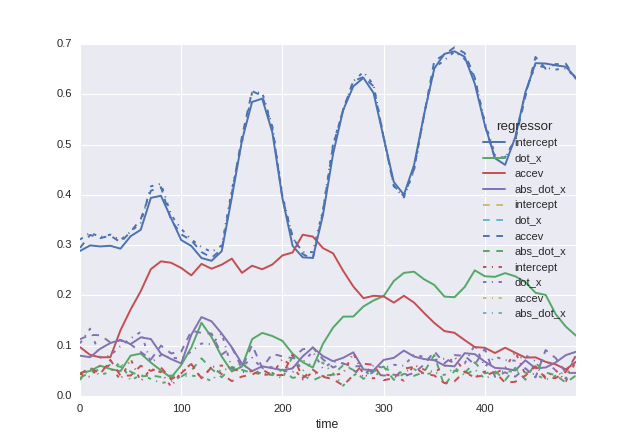

<IPython.core.display.Javascript object>


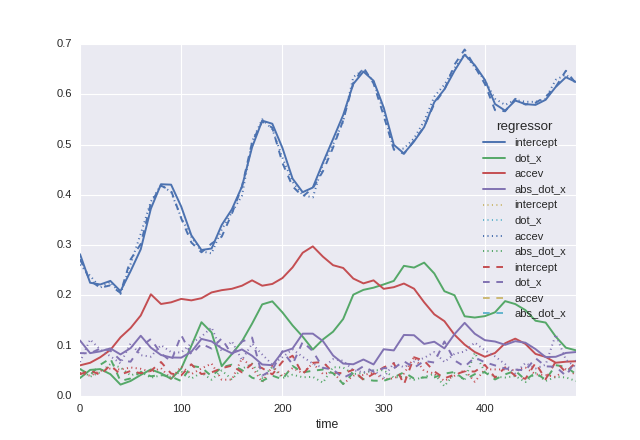

<IPython.core.display.Javascript object>


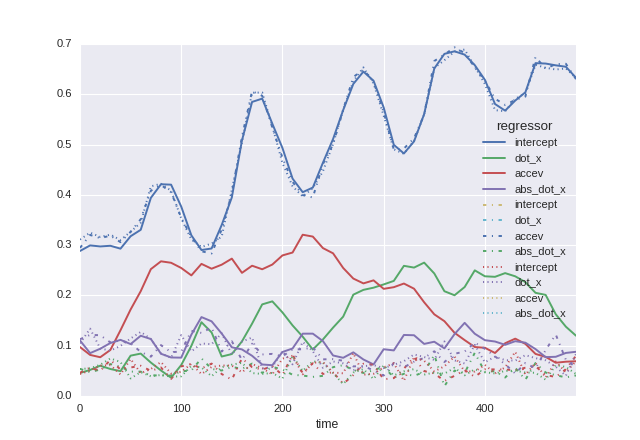

In [16]:
sub = 4
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='max')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='min')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='absmax')

## Determine relative 'power' of 20 and 60 ms peaks in intercept

In [17]:
times = first_level.index.levels[2]

# determine mean in 100 ms bins
for tbin in range(int(np.ceil(times[-1] / 100))):
    tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
    
    binmean = first_level.loc[(0, slice(None), tbin_times), 
        (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()
    
# first 200 ms


In [18]:
tbin=1
times = first_level.index.levels[2]
tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
first_level.loc[(0, slice(None), tbin_times), (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()

subject  measure  regressor
2        beta     intercept    0.389247
3        beta     intercept    0.264310
4        beta     intercept    0.424077
5        beta     intercept    0.432001
6        beta     intercept    0.558149
7        beta     intercept    0.336534
8        beta     intercept    0.398896
9        beta     intercept    0.399745
10       beta     intercept    0.294193
11       beta     intercept    0.296134
12       beta     intercept    0.620539
13       beta     intercept    0.384772
15       beta     intercept    0.426321
16       beta     intercept    0.557392
17       beta     intercept    0.504056
18       beta     intercept    0.559385
19       beta     intercept    0.409016
20       beta     intercept    0.470337
21       beta     intercept    0.324355
22       beta     intercept    0.394971
23       beta     intercept    0.330052
24       beta     intercept    0.417385
25       beta     intercept    0.604494
26       beta     intercept    0.555887
27       bet